<a href="https://colab.research.google.com/github/d-sanjukta/Lyrics-Generator/blob/main/1_Model_Comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## <b><u>Language Model Comparision</b></u> :
<h4>
To compare the performance of three different lyric-generating models (**Bi-directional LSTM, GPT2, and Distill-GPT2**) specifically in the rock genre, the following steps will be undertaken:

*  **Training**: The models will be trained using a dataset consisting of rock song lyrics. While the Bi-directional LSTM model will be trained, it will not be utilized for lyric generation as it is expected that its performance will not surpass that of GPT2 and Distill-GPT2. Instead, it will serve as a baseline model to monitor the trend of loss during the training process.

* **Sample Selection**: A set of 20 random samples will be selected from the validation dataset.

* **Prediction Generation**: For each sample, GPT2 and Distill-GPT2 models will be used. The models will be provided with the initial 28 tokens of the lyrics and tasked with generating the subsequent 128 tokens to complete the lyrics. This approach aims to evaluate the models' ability to maintain the lyrical flow and capture the essence of the rock genre.

* **Result Comparison**: The generated predictions from GPT2 and Distill-GPT2 models will be compared for each sample. The evaluation criteria will consider lyrical coherence and thematic consistency. The objective will be to determine which model demonstrates comparatively superior performance in generating high-quality and genre-appropriate lyrics.

<h4>
By following this approach, the outputs of GPT2 and Distill-GPT2 models will be analyzed and compared. Additionally, the Bi-directional LSTM model will serve as a reference point to assess the relative performance of the other models. This comprehensive evaluation will provide insights into the strengths and weaknesses of each model, enabling informed conclusions about their respective capabilities in the given rock genre context.

________________________________________________________________________________________________________

In [ ]:
# Import the necessary libraries
import pickle
import numpy as np
import pandas as pd

import seaborn as sns
import re
import string
import tensorflow as tf
import keras
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

from keras.models import Sequential
from tensorflow.keras.models import Model

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Embedding, SimpleRNN, Dense, LSTM , GRU, Bidirectional

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### DATA PRE-PROCESSING


In [ ]:
# Getting the pickle file for pre-processing.

# load variables from the file on Google Drive
with open('/content/drive/MyDrive/UNIV.AI/AI-3 Language Models/Project/Project Landing /Datasets/reduced_genre_dataset/Rock_final.pickle', 'rb') as f:
    rock_songs = pickle.load(f)

rock_songs.head()

,title,tag,artist,year,views,lyrics
0,Subterranean Homesick Blues,rock,Bob Dylan,1965,180196,"Johnny's in the basement, mixin' up the medic..."
1,Bohemian Rhapsody,rock,Queen,1975,9247817,Is this the real life? Is this just fantasy? ...
2,Neighborhood 2 Laïka,rock,Arcade Fire,2005,73848,"Alexander, our older brother Set out for a gr..."
3,White Riot,rock,The Clash,1977,41406,"1,2,3,4 White riot, I wanna riot White riot..."
4,Leave the Bourbon on the Shelf,rock,The Killers,2007,23937,Shaking like the devil when she lets me go Go...


In [ ]:
## FUNCTION TO PRE_PROCESS THE DATA :

def pre_processing_lyrics(dataset):
  '''
  INPUT : Dataset having different features like : genre , artist , title , view , lyrics etc
  Here, we are interested only in lyrics.
  Output: Processed list of Songs/ lyrics
  '''
  # extracting lyrics from dataset
  songs  = list(dataset['lyrics'])

  #Drop the songs with lyrics that are too short
  lyrics = []
  for song in songs:
    if len(song.split(' ')) > 150:
      lyrics.append(song)

  # For training We will use first 30000 lyrics only. (due to time and system constraints)
  if len(lyrics) > 30000:
    lyrics = lyrics[:30000]

  # REMOVE ANY WORDS CONTAINING NUMERICAL VALUE and SPECIAL CHARACTERS.
  final_lyrics = []
  pattern = re.compile(r'\b[^\W\d_]+\b')  # Regex pattern to match words without numerical characters

  for lyric in lyrics:
        splits = lyric.split(',')
        cleaned_splits = []

        for split in splits:
            cleaned_split = re.sub(r'[^\w\s\']', '', split)
            filtered_split = ' '.join(word for word in cleaned_split.split() if pattern.match(word))
            cleaned_splits.append(filtered_split)

        final_lyrics.append(','.join(cleaned_splits))


  # Applygin 'next line' token at every capital Letter in lyrics and 'end of sequence' token.
  final_lyrics  = [' '.join(['\n' + word if (word[0]).isupper() else word for word in songs.replace('  ', '').split(' ')] + [' </s>']) for songs in final_lyrics]
  print (f"Number of Total Processed Lyrics : {len(final_lyrics)}")

  return final_lyrics

In [ ]:
# Pre-process the lyrics
processed_lyrics = pre_processing_lyrics(rock_songs)

Number of Total Processed Lyrics : 30000


In [ ]:
processed_lyrics[0]

"\nJohnny's in the basement,mixin' up the medicine \nI'm on the pavement,thinkin' about the government \nThe man in a trench coat,badge out,laid off \nSays he's got a bad cough,wants to get it paid off \nLook out kid,it's somethin' you did \nGod knows when,but you're doin' it again \nYou better duck down the alleyway,looking for a new friend \nThe man in the coonskin cap in a pig pen \nWants dollar bills you only got \nMaggie comes fleet foot,face full of black soot \nTalkin' that the heat put plants in the bed,but \nPhone's tapped anyway \nMaggie says the many say \nThey must bust in early \nMay \nOrders from the \nDA \nLook out kid,don't matter what you did \nWalk on your tip toes,dont tie no bows \nBetter stay away from those that carry around a fire hose \nKeep a clean nose,watch the plainclothes \nYou don't need a weather man to know which way the wind blows \nOh,get sick,get well,hang around a ink well \nHang bail,hard to tell if anything is gonna sell \nTry hard,get barred,get b

###  Model : Bi-directional LSTM

In [ ]:
# Preparing training and validation sets:

# combining all lyrics together into one sentence:
rock_songs = ' '.join(processed_lyrics)


# Function to create lyrics of 128 words:

def create_sentences(lyrics, w = 128) :

  sentences = []

  lyrics = lyrics.split( ' ')
  length  = len(lyrics)

  n = length // w   # this gives the total number sentences form with 'w' words in it.

  a = 0
  b = w
  for i in range (n):
    sentences.append(lyrics[a:b])
    a+= w
    b+= w

  return sentences

# Calling the function to create the sentences of equal number of words:

lyrics_128 = create_sentences(rock_songs)

# We do this because of system and time constraints
if len(lyrics_128) > 20000:
  lyrics_128 = lyrics_128[:20000]

In [ ]:
# TOKENIZATION

# Creating the instance of tokenizer
n_vocab = 15000

tokenizer = tf.keras.preprocessing.text.Tokenizer(

    num_words= n_vocab,
    filters='',
    lower=True,
    split=' ',
    oov_token= "<UNK>",
)

tokenizer.fit_on_texts(rock_songs.split(' '))


# TOKENIZING THE SENTENCES :
tokenized_lyrics = tokenizer.texts_to_sequences(lyrics_128)


# Preparing the predictors and responce variables:
'''
suppose we have a sentence : [1,2,3,4,5,6,7,8, ........127,128] then
our x_train will be : [1,2,3,4,5,6,7,8........,126,127] and
out y_train will be : [2,3,4,5,6,7,8.........., 127, 128]
'''
X = [tokens[:-1] for tokens in tokenized_lyrics]
Y = [tokens[1: ] for tokens in tokenized_lyrics]

# print (X[0])
# print (Y[0])

## Lets pad the datasets , to make all sentences of equal length.
max_len = 128

X_padded = tf.keras.utils.pad_sequences(X,maxlen=max_len-1,padding='post')
Y_padded = tf.keras.utils.pad_sequences(Y,maxlen=max_len-1,padding='post')


In [ ]:
# Common Parameters we will be using to make models
embedding_dim = 1000
hidden_dim_1 = 500
hidden_dim_2 = 250
hidden_dim_3 = 50


###############################################################################################

# Initializing the bi-directional LSTM model
inputs = Input(shape=(None,))

# Adding an Embedding layer
x = Embedding(input_dim=n_vocab, output_dim=embedding_dim,mask_zero = True)(inputs)

# Adding bi-directional LSTM layers based on the input parameters
x = Bidirectional(LSTM(units=hidden_dim_1, activation='tanh', return_sequences=True))(x)  # First LSTM layer
x = Bidirectional(LSTM(units=hidden_dim_2, activation='tanh',return_sequences=True))(x)  # second LSTM layer

# Adding a Dense layer with the number of classes and softmax activation
outputs = Dense(units=n_vocab, activation='softmax')(x)

# Finalizing the model
model_biLSTM = Model(inputs=inputs, outputs=outputs)

# Compiling the model
model_biLSTM.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model_biLSTM.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_1 (Embedding)     (None, None, 1000)        15000000  
                                                                 
 bidirectional_2 (Bidirectio  (None, None, 1000)       6004000   
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, None, 500)        2502000   
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, None, 15000)       7515000   
                                                                 
Total params: 31,021,000
Trainable params: 31,021,000
Non-t

In [ ]:
# Training the Model:
history_biLSTM = model_biLSTM.fit(X_padded,Y_padded, validation_split = 0.20, epochs = 6, verbose = 1 , batch_size = 16)

Epoch 1/6
320/320 [==============================] - 120s 335ms/step - loss: 6.6893 - accuracy: 0.0668 - val_loss: 6.6429 - val_accuracy: 0.0642
Epoch 2/6
320/320 [==============================] - 92s 288ms/step - loss: 6.6016 - accuracy: 0.0669 - val_loss: 6.6508 - val_accuracy: 0.0642
Epoch 3/6
320/320 [==============================] - 91s 285ms/step - loss: 6.6024 - accuracy: 0.0668 - val_loss: 6.6445 - val_accuracy: 0.0642
Epoch 4/6
320/320 [==============================] - 90s 280ms/step - loss: 6.5865 - accuracy: 0.0669 - val_loss: 6.6085 - val_accuracy: 0.0642
Epoch 5/6
320/320 [==============================] - 89s 279ms/step - loss: 6.0215 - accuracy: 0.1070 - val_loss: 3.9691 - val_accuracy: 0.3964
Epoch 6/6
320/320 [==============================] - 91s 284ms/step - loss: 2.5543 - accuracy: 0.6492 - val_loss: 1.8038 - val_accuracy: 0.7723


In [ ]:
## SAVING ITS CORRESPONDING TOKENIZER IN GOOGLE DRIVE:
with open('/content/drive/MyDrive/UNIV.AI/Project AI 3 NLP/Project Landing /Saved Models/Comparing Models/bi_LSTM_model.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

# Saving the Model Weights:  saving model as .h5 file
model_biLSTM.save_weights('/content/drive/MyDrive/UNIV.AI/Project AI 3 NLP/Project Landing /Saved Models/Comparing Models/bi_LSTM_model_weights.h5')


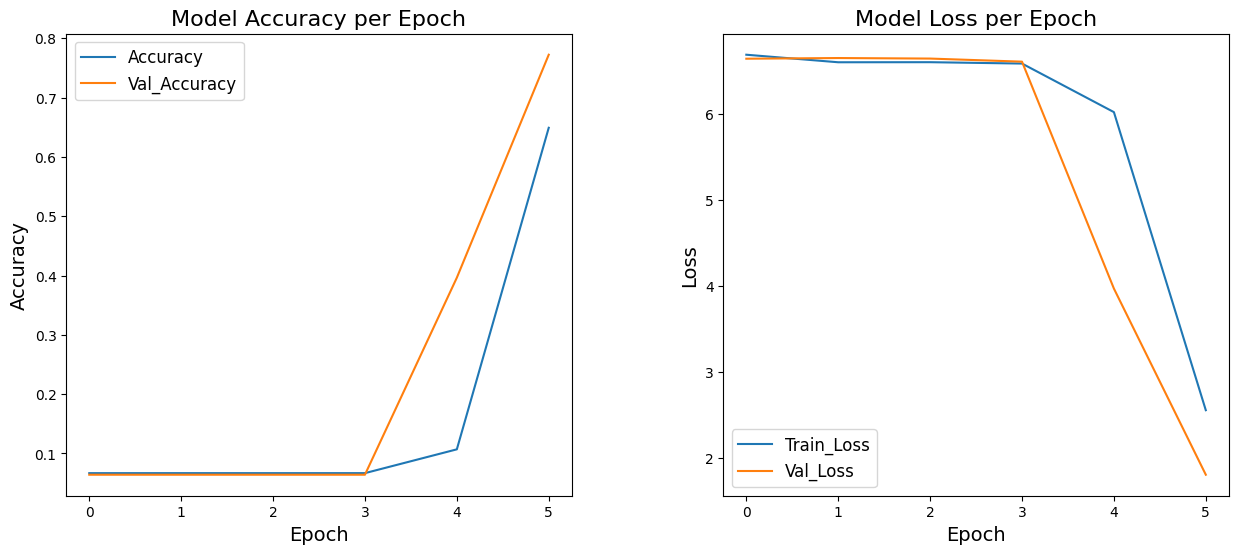

In [ ]:
# PLOTTING THE TRAINING DATA : ACCURACY AND LOSS
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(15, 6))
fig.subplots_adjust(wspace=0.3)

ax[0].set_title('Model Accuracy per Epoch', fontsize=16)
ax[0].set_xlabel('Epoch', fontsize=14)
ax[0].set_ylabel('Accuracy', fontsize=14)

ax[0].plot(history_biLSTM.history['accuracy'], label='Accuracy')
ax[0].plot(history_biLSTM.history['val_accuracy'], label='Val_Accuracy')
ax[0].legend(fontsize=12)

ax[1].set_title('Model Loss per Epoch', fontsize=16)
ax[1].set_xlabel('Epoch', fontsize=14)
ax[1].set_ylabel('Loss', fontsize=14)

ax[1].plot(history_biLSTM.history['loss'], label='Train_Loss')
ax[1].plot(history_biLSTM.history['val_loss'], label='Val_Loss')
ax[1].legend(fontsize=12)

plt.show()

### Data Processing For Transformer Models

In [ ]:
! pip install transformers
! pip install datasets

from transformers import TFAutoModelForCausalLM, AutoTokenizer, AdamWeightDecay, pipeline, create_optimizer

In [ ]:
# Split the lyrics into train and validation sets

val_split = 0.2  # 20% of the data will be used for validation
max_seq_length = 128  # Maximum sequence length to use for training

split_index = int(len(processed_lyrics) * (1 - val_split))
train_lyrics = processed_lyrics[:split_index]
val_lyrics = processed_lyrics[split_index:]

In [ ]:
len(train_lyrics) , len(val_lyrics)

(24000, 6000)

###  Model : GPT2

In [ ]:
# Load the pre-trained GPT-2 tokenizer
tokenizer = AutoTokenizer.from_pretrained("gpt2")

# Load the pre-trained GPT-2 small model
model = TFAutoModelForCausalLM.from_pretrained("gpt2", max_length=512)

All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at gpt2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


In [ ]:
# Tokenize the train and validation lyrics
encoded_train_lyrics = np.concatenate([tokenizer.encode(l) for l in train_lyrics if tokenizer.encode(l)])
encoded_val_lyrics = np.concatenate([tokenizer.encode(l) for l in val_lyrics if tokenizer.encode(l)])

Token indices sequence length is longer than the specified maximum sequence length for this model (1208 > 1024). Running this sequence through the model will result in indexing errors


In [ ]:
# Function to make chunks of equal number of words: default = 128 words/tokens

def create_chunks(tokens , w = 128):
  chunks = [] # list to contains chunks of 128 words.

  length = len(tokens)
  n = length // w       # number of chunks available
  a = 0
  b = w

  for i in range(n):
    chunks.append(tokens[a:b])
    a+=w
    b+=w

  return chunks

# Creating chunks using the above defined function
encoded_train_lyrics_ = create_chunks(encoded_train_lyrics)[:20000]

encoded_val_lyrics_ = create_chunks(encoded_val_lyrics)[:4000]


# Define the input processing function
def preprocess(inputs):

    input_ids = inputs[:-1]
    target_ids = inputs[1:]

    return {'input_ids': input_ids, 'attention_mask': tf.ones_like(input_ids)}, target_ids

# Preprocess the datasets
train_dataset = tf.data.Dataset.from_tensor_slices(encoded_train_lyrics_)
val_dataset = tf.data.Dataset.from_tensor_slices(encoded_val_lyrics_)
train_dataset = train_dataset.map(preprocess).shuffle(10000).batch(16)
val_dataset = val_dataset.map(preprocess).batch(16)

In [ ]:
# Set up the optimizer and loss function
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Compile the model
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

# Set up the training parameters
num_epochs = 5

model.summary()

Model: "tfgpt2lm_head_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 transformer (TFGPT2MainLaye  multiple                 124439808 
 r)                                                              
                                                                 
Total params: 124,439,808
Trainable params: 124,439,808
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Begin training
history_GPT2 = model.fit(train_dataset, epochs=num_epochs, validation_data=val_dataset)

Epoch 1/5
1250/1250 [==============================] - 907s 692ms/step - loss: 2.6840 - accuracy: 0.4993 - val_loss: 2.5740 - val_accuracy: 0.5093
Epoch 2/5
1250/1250 [==============================] - 865s 691ms/step - loss: 2.5383 - accuracy: 0.5161 - val_loss: 2.5619 - val_accuracy: 0.5112
Epoch 3/5
1250/1250 [==============================] - 865s 692ms/step - loss: 2.4501 - accuracy: 0.5263 - val_loss: 2.5655 - val_accuracy: 0.5114
Epoch 4/5
1250/1250 [==============================] - 865s 692ms/step - loss: 2.3735 - accuracy: 0.5352 - val_loss: 2.5784 - val_accuracy: 0.5102
Epoch 5/5
1250/1250 [==============================] - 864s 691ms/step - loss: 2.3014 - accuracy: 0.5441 - val_loss: 2.5877 - val_accuracy: 0.5105


In [ ]:
## SAVING ITS CORRESPONDING TOKENIZER IN GOOGLE DRIVE:
with open('/content/drive/MyDrive/UNIV.AI/Project AI 3 NLP/Project Landing /Saved Models/Comparing Models/gpt2_model.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

# Saving the Model Weights:  saving model as .h5 file
model.save_weights('/content/drive/MyDrive/UNIV.AI/Project AI 3 NLP/Project Landing /Saved Models/Comparing Models/gpt2_model_weights.h5')


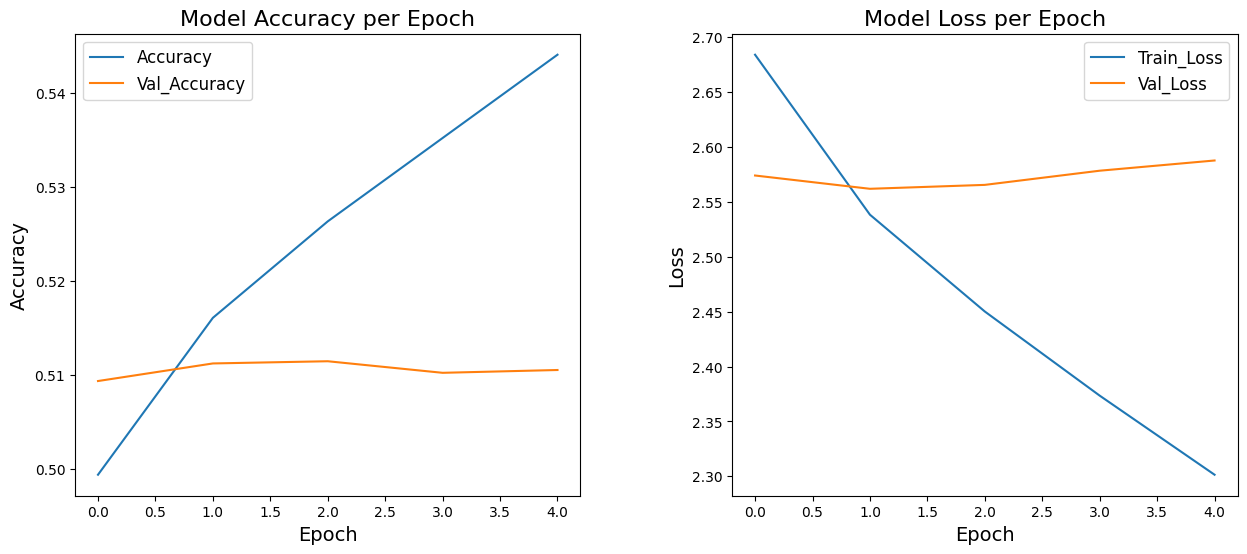

In [ ]:
# PLOTTING THE TRAINING DATA : ACCURACY AND LOSS
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(15, 6))
fig.subplots_adjust(wspace=0.3)

ax[0].set_title('Model Accuracy per Epoch', fontsize=16)
ax[0].set_xlabel('Epoch', fontsize=14)
ax[0].set_ylabel('Accuracy', fontsize=14)

ax[0].plot(history_GPT2.history['accuracy'], label='Accuracy')
ax[0].plot(history_GPT2.history['val_accuracy'], label='Val_Accuracy')
ax[0].legend(fontsize=12)

ax[1].set_title('Model Loss per Epoch', fontsize=16)
ax[1].set_xlabel('Epoch', fontsize=14)
ax[1].set_ylabel('Loss', fontsize=14)

ax[1].plot(history_GPT2.history['loss'], label='Train_Loss')
ax[1].plot(history_GPT2.history['val_loss'], label='Val_Loss')
ax[1].legend(fontsize=12)

plt.show()

###  Model : Distill_GPT2

In [ ]:
# Load the pre-trained GPT-2 tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilgpt2")

# Load the pre-trained GPT-2 small model
model = TFAutoModelForCausalLM.from_pretrained("distilgpt2", max_length=512)

All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at distilgpt2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


In [ ]:
# Tokenize the train and validation lyrics
encoded_train_lyrics = np.concatenate([tokenizer.encode(l) for l in train_lyrics if tokenizer.encode(l)])
encoded_val_lyrics = np.concatenate([tokenizer.encode(l) for l in val_lyrics if tokenizer.encode(l)])

Token indices sequence length is longer than the specified maximum sequence length for this model (1208 > 1024). Running this sequence through the model will result in indexing errors


In [ ]:
# Function to make chunks of equal number of words: default = 128 words/tokens

def create_chunks(tokens , w = 128):
  chunks = [] # list to contains chunks of 128 words.

  length = len(tokens)
  n = length // w       # number of chunks available
  a = 0
  b = w

  for i in range(n):
    chunks.append(tokens[a:b])
    a+=w
    b+=w

  return chunks

# Creating chunks using the above defined function
encoded_train_lyrics_ = create_chunks(encoded_train_lyrics)[:20000]

encoded_val_lyrics_ = create_chunks(encoded_val_lyrics)[:4000]


# Define the input processing function
def preprocess(inputs):

    input_ids = inputs[:-1]
    target_ids = inputs[1:]

    return {'input_ids': input_ids, 'attention_mask': tf.ones_like(input_ids)}, target_ids

# Preprocess the datasets
train_dataset = tf.data.Dataset.from_tensor_slices(encoded_train_lyrics_)
val_dataset = tf.data.Dataset.from_tensor_slices(encoded_val_lyrics_)
train_dataset = train_dataset.map(preprocess).shuffle(10000).batch(16)
val_dataset = val_dataset.map(preprocess).batch(16)

In [ ]:
# Set up the optimizer and loss function
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Compile the model
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

# Set up the training parameters
num_epochs = 5

model.summary()

Model: "tfgpt2lm_head_model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 transformer (TFGPT2MainLaye  multiple                 81912576  
 r)                                                              
                                                                 
Total params: 81,912,576
Trainable params: 81,912,576
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Begin training
history_dist_GPT2 = model.fit(train_dataset, epochs=num_epochs, validation_data=val_dataset)

Epoch 1/5
1250/1250 [==============================] - 623s 482ms/step - loss: 2.8256 - accuracy: 0.4800 - val_loss: 2.6980 - val_accuracy: 0.4930
Epoch 2/5
1250/1250 [==============================] - 603s 482ms/step - loss: 2.6841 - accuracy: 0.4958 - val_loss: 2.6748 - val_accuracy: 0.4960
Epoch 3/5
1250/1250 [==============================] - 565s 452ms/step - loss: 2.6096 - accuracy: 0.5040 - val_loss: 2.6637 - val_accuracy: 0.4975
Epoch 4/5
1250/1250 [==============================] - 603s 482ms/step - loss: 2.5493 - accuracy: 0.5106 - val_loss: 2.6614 - val_accuracy: 0.4985
Epoch 5/5
1250/1250 [==============================] - 603s 483ms/step - loss: 2.4949 - accuracy: 0.5167 - val_loss: 2.6701 - val_accuracy: 0.4986


In [ ]:
## SAVING ITS CORRESPONDING TOKENIZER IN GOOGLE DRIVE:
with open('/content/drive/MyDrive/UNIV.AI/Project AI 3 NLP/Project Landing /Saved Models/Comparing Models/distillgpt2_model.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

# Saving the Model Weights:  saving model as .h5 file
model.save_weights('/content/drive/MyDrive/UNIV.AI/Project AI 3 NLP/Project Landing /Saved Models/Comparing Models/distillgpt2_model_weights.h5')


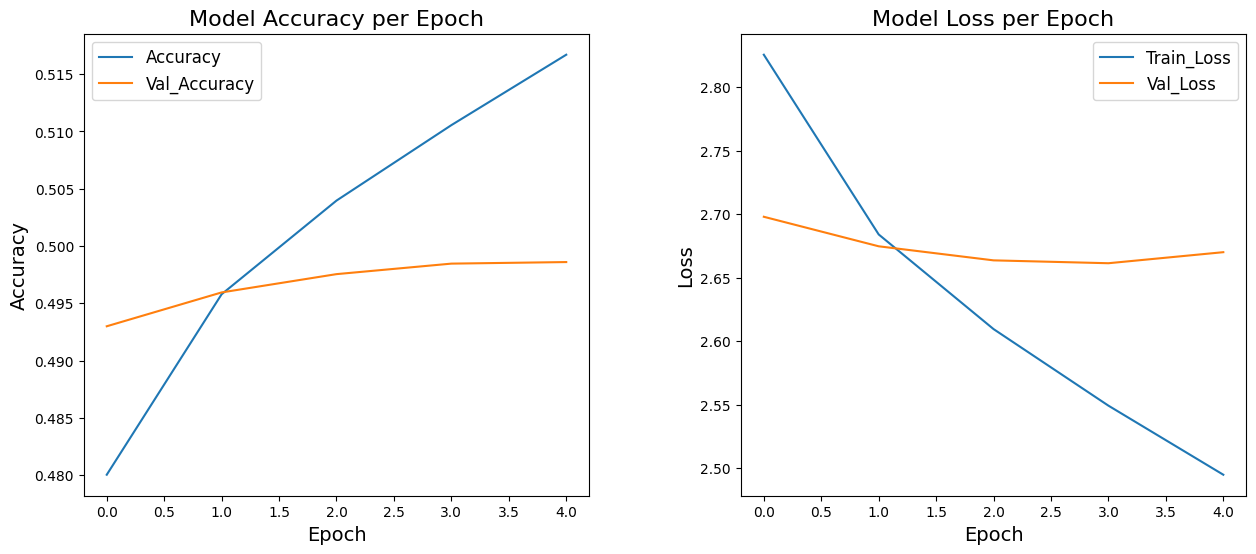

In [ ]:
# PLOTTING THE TRAINING DATA : ACCURACY AND LOSS
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(15, 6))
fig.subplots_adjust(wspace=0.3)

ax[0].set_title('Model Accuracy per Epoch', fontsize=16)
ax[0].set_xlabel('Epoch', fontsize=14)
ax[0].set_ylabel('Accuracy', fontsize=14)

ax[0].plot(history_dist_GPT2.history['accuracy'], label='Accuracy')
ax[0].plot(history_dist_GPT2.history['val_accuracy'], label='Val_Accuracy')
ax[0].legend(fontsize=12)

ax[1].set_title('Model Loss per Epoch', fontsize=16)
ax[1].set_xlabel('Epoch', fontsize=14)
ax[1].set_ylabel('Loss', fontsize=14)

ax[1].plot(history_dist_GPT2.history['loss'], label='Train_Loss')
ax[1].plot(history_dist_GPT2.history['val_loss'], label='Val_Loss')
ax[1].legend(fontsize=12)

plt.show()

__________________________________________________

### MODEL EVALUATION

In [ ]:
# Preparing the Test Set
test_set = [" ".join(lyric.split(' ')[:28]) for lyric in val_lyrics[:20]]             # We will feed first 28 words to the model. This acts as a prompt for the trained model
val_set = [" ".join(lyric.split(' ')[:128]) for lyric in val_lyrics[:20]]             # Generate 128 from the models and compare those with this val_set.

In [ ]:
## Getting Prediction from trained Model:

'''
Input : input prompt, model and its tokenizer
Output : Predicted Lyrics
'''

def get_predictions (prompts,model, tokenizer,
                     max_length = 170,
                     num_beams = 2,
                     temperature = 0.4,
                     no_repeat_ngram_size=3,
                     num_return_sequences=1 ):
  generations = []
  for prompt in prompts:

    prompt = prompt.lstrip().rstrip()
    # encoding the input text
    input_ids = tokenizer([prompt])

    # Getting output:
    beam_output = model.generate(   input_ids['input_ids'],
                                    max_length = max_length,
                                    num_beams = num_beams,
                                    temperature = temperature,
                                    no_repeat_ngram_size=no_repeat_ngram_size,
                                    num_return_sequences=num_return_sequences
                                  )
    # decoding the output tokens
    output_sequences = [tokenizer.decode(seq, clean_up_tokenization_spaces=True) for seq in beam_output]

    # saving our predicted lyrics in a list
    generations.append(output_sequences[0])

  # Return the generated lyrics
  return generations

> Lyrics Generations from GPT2 model

In [ ]:
# First we will get the genertions from GPT2 model:

# Load the pre-trained GPT-2 tokenizer
tokenizer = AutoTokenizer.from_pretrained("gpt2")

# Load the pre-trained GPT-2 small model
model = TFAutoModelForCausalLM.from_pretrained("gpt2", max_length=512)
# Load the model weights
model.load_weights('/content/drive/MyDrive/UNIV.AI/AI-3 Language Models/Project/Project Landing /Saved Models/Comparing Models/gpt2_model_weights.h5')

# Getting the Predictions
gpt_generations = get_predictions(test_set , model , tokenizer )

> Lyrics Generations from Distill-GPT2 model

In [ ]:
# First we will get the genertions from GPT2 model:

# Load the pre-trained GPT-2 tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilgpt2")

# Load the pre-trained GPT-2 small model
model = TFAutoModelForCausalLM.from_pretrained("distilgpt2", max_length=512)
# Load the model weights
model.load_weights('/content/drive/MyDrive/UNIV.AI/AI-3 Language Models/Project/Project Landing /Saved Models/Comparing Models/distillgpt2_model_weights.h5')

# Getting the Predictions
distilgpt_generations = get_predictions(test_set , model , tokenizer )

> Creating a dataframe to summary everything in one file :

In [ ]:
df = pd.DataFrame()

df['prompt'] = test_set
df['validation_set'] = val_set
df['gpt2_generations'] = gpt_generations
df['distillgpt_generation'] = distilgpt_generations

display(df.head())

print(f'''
One Example:


PROMPT :\n{df['prompt'][0]}


Val_lyrics : \n{df['validation_set'][0]}


GPT_predicition : \n{df['gpt2_generations'][0]}


Distill_GPT_predicition : \n{df['distillgpt_generation'][0]}
''')

,prompt,validation_set,gpt2_generations,distillgpt_generation
0,\nThe boy stood in the burning slum \nBetter t...,\nThe boy stood in the burning slum \nBetter t...,The boy stood in the burning slum \nBetter tim...,The boy stood in the burning slum \nBetter tim...
1,"\nFour for a pound your face flannels,three fo...","\nFour for a pound your face flannels,three fo...","Four for a pound your face flannels,three for ...","Four for a pound your face flannels,three for ..."
2,\nJacques \nLamure is a volunteer fireman \nHe...,\nJacques \nLamure is a volunteer fireman \nHe...,Jacques \nLamure is a volunteer fireman \nHe l...,Jacques \nLamure is a volunteer fireman \nHe l...
3,\nI feel your knife as it goes right in \nCut ...,\nI feel your knife as it goes right in \nCut ...,I feel your knife as it goes right in \nCut to...,I feel your knife as it goes right in \nCut to...
4,"\nTulip \nBaroo,Tulip \nBaroo \nThe magnetic r...","\nTulip \nBaroo,Tulip \nBaroo \nThe magnetic r...","Tulip \nBaroo,Tulip \nBaroo \nThe magnetic rol...","Tulip \nBaroo,Tulip \nBaroo \nThe magnetic rol..."



One Example: 


PROMPT :

The boy stood in the burning slum 
Better times had to come 
Fate lay in the hands that clap 
The muscles that move 
The heart to rap 
He


Val_lyrics : 

The boy stood in the burning slum 
Better times had to come 
Fate lay in the hands that clap 
The muscles that move 
The heart to rap 
He went up on money street 
Wavin' and poppin' to the beat 
Off his wits and on his feet 
He worked a coin from the cold concrete 
Movers and shakers come on 
You got what it takes to make it 
Movers and shakers come on 
Even if you have to fake it 
Where the highways meets the lights 
With a red bandanna,rapid wipes 
He shines glass,he cleans chrome 
He'll accept what he gets thrown 
This man earns its understood 
Times are bad and he's making good 
Down on him but he's got it beat 
He's working coin from the cold concrete


GPT_predicition : 
The boy stood in the burning slum 
Better times had to come 
Fate lay in the hands that clap 
The muscles that move 
The heart to ra

In [ ]:
# Saving this .CSV file for future use:
df.to_csv('/content/drive/MyDrive/UNIV.AI/AI-3 Language Models/Project/Project Landing /Saved Models/Comparing Models/Lyrics_Generations.csv', index=False)

#### EVALUATION

#### 1. ROUGE (Recall-Oriented Understudy for Gisting Evaluation)

In [ ]:
!pip install rouge

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from rouge import Rouge

def calculate_rouge(actual_lyrics, generated_lyrics):

  scores = [] # This holds the rouge['f1'] scores for each lyrics

  for actual , generated in zip(actual_lyrics , generated_lyrics):
    rouge = Rouge()
    scores.append(rouge.get_scores(generated, actual, avg=True)['rouge-1']['f'])


  return sum(scores)/20  # we return the average score of the whole generatioon


> Getting Rouge Scores for Lyrics Generated By GPT2 and DistillGPT2 Model:


In [ ]:
gpt2_rouge_score = calculate_rouge(df['validation_set'], df['gpt2_generations'])
distil_gpt2_rouge_score = calculate_rouge(df['validation_set'], df['distillgpt_generation'])

print (f'''
AVERAGE ROUGE SCORE FOR:
  GPT2        : {gpt2_rouge_score:.4f}
  Distil_GPT2 : {distil_gpt2_rouge_score:.4f}
''')


AVERAGE ROUGE SCORE FOR: 
  GPT2        : 0.3978
  Distil_GPT2 : 0.4004



INFERENCE ⏬

No significant difference between rouge scores of these models.

> HUMAN EVALUATION

In [ ]:
# We ourselves will try to evaluate the Generated Lyrics based on Cohesiveness and Rhymness

for gpt2, distilgpt2 in zip(df['gpt2_generations'], df['distillgpt_generation']):
  display(f'GPT2: {gpt2}')
  print('\n')
  display(f'distilGPT2 : {distilgpt2}')
  print('\n\n...............................................................................................................................................................................')

"GPT2: The boy stood in the burning slum \nBetter times had to come \nFate lay in the hands that clap \nThe muscles that move \nThe heart to rap \nHe was a boy,he was a man \nA boy,a boy \nAnd \nI'm a boy  </s>\nI was born in \nMay,I was raised in the land of the free \nIn the land that you call home \nYou call home,you call home to me \nWe are the children of \nGod,we are the ones who are saved \nFrom the hands of the wicked \nWho have taken our lives \nTo save us from the clutches of the damned \nBut we are the chosen ones \nFor we are not alone \nOur"

"distilGPT2 : The boy stood in the burning slum \nBetter times had to come \nFate lay in the hands that clap \nThe muscles that move \nThe heart to rap \nHe's got a heart to crack \nAnd he's got the heart to break \nBut \nI don't want to be the one to blame \nFor all the things that  </s>\nI've been waiting for you \nYou're the only one \nThat's gonna save me \nIt's the only thing \nSomeday you'll see \nWhen you're gone \nYour eyes are open wide \nThey're open wide,they're open \nThere's nothing left to say \nSo \nIm going to tell you what you want \nTo hear \nWhat"



...............................................................................................................................................................................


"GPT2: Four for a pound your face flannels,three for a pound your tea towels \nFour for a pound your face flannels,three for a pound your tea towels \nI hear you say \nYou can't get enough of me \nBut \nIm not the only one \nAnd \nIll be the last one  </s>\nI was born in \nMay \nIn the summer of \nJune \nWith my mother's name \nOn my father's side \nMy father's name was \nBobby \nMcGreevy \nHe was a big man \nA big man with a big mouth \nBig man with big hands \nYeah,he was a real big guy \nOh,he had a big \nG \nDaddy \n"

'distilGPT2 : Four for a pound your face flannels,three for a pound your tea towels \nFour for a pound your face flannels,three for a pound your tea towels \nI hear the sound of your voice,I hear your voice \nBut \nIm not sure if youre right or wrong \nAnd \nIll be waiting for you \nFor you  </s>\nIve been waiting for a miracle \nTo come true \nTheres a miracle in my life \nA miracle in the world \nIn my life,in my heart \nMy life,my life,I dont know \nWhat \nGod is \nHe said \nIf youre born in the morning \nThen youll be born \nYoull be raised in the evening \nWhen youre'



...............................................................................................................................................................................


"GPT2: Jacques \nLamure is a volunteer fireman \nHe longs to give his life \nSaving a nice old man and his wife \nWhen their house is filled with flames \nEarning a living \nFrom the money he makes \nAnd the money that he saves \nThe money that \nI earn \nIs a very good thing \nIt's a very nice thing  </s>\nI've been waiting for you \nFor a long time \nYou've been knocking at my door \nWaiting for me to come and take you home \nBut \nIm not coming home,I'm coming home to you now \nNow \nIll be waiting for the sun to rise \nOh \nLord \nWell,Ill be looking for you,"

"distilGPT2 : Jacques \nLamure is a volunteer fireman \nHe longs to give his life \nSaving a nice old man and his wife \nWhen their house is filled with flames \nEarning a little bit of money \nTo pay the rent,to pay the bill \nAnd to pay the bills \nFor the money,for the money  </s>\nI was born in the \nNew \nYork \nCity \nI'm a \nJazz \nDJ,I'm an \nAmin \nRita \nShe's a ṗl \nMexican girl \nWho's got a iced tea in her hand \nOh,she's a girl who's got some \nFrench \nIrish \nTambourine"



...............................................................................................................................................................................


"GPT2: I feel your knife as it goes right in \nCut to my core but \nI'm not bleeding \nAll that you say tryin' to make me small \nWell the knife's in my hand \nAnd \nIm not bleeding,Im not dying \nYou say you want me to be your friend \nBut \nIll never give you my love \nNo,Ill never ever give you that \nYour knife is my knife \nMy knife is your knife  </s>\nI've been waiting for you \nFor so long \nIt's been a long,long time \nTo see you through \nNow you've come to take me away \nFrom all of my fears \nSo long,it's been so long,I've waited for you to come "

"distilGPT2 : I feel your knife as it goes right in \nCut to my core but \nI'm not bleeding \nAll that you say tryin' to make me small \nWell the only thing that you can do is say \nYou're not the only one \nAnd you're the one that you're gonna have to lose \nSo \nIll tell you what \nIm gonna do  </s>\nIve been waiting for you \nWaiting for you to come and take me home \nBut youre not the first to come around \nTheres a lot of things \nThat youve got to do \nTo make me feel like youre the one you want me to be \nWhen youre with me \nIf you want to be with me,youll be with"



...............................................................................................................................................................................


"GPT2: Tulip \nBaroo,Tulip \nBaroo \nThe magnetic roller skater wears a bonnet of blue \nBonnet of blue \nTulip \nBaroom,though you are four walls \nYou don't make a room,don't make a bed \nAnd \nI don't know why \nIt's not your fault,it's not my fault \nBut \nGod,I'm a \nMagnetic \nRoller \nSkater  </s>\nI was born in \nMay,I was raised by \nMama \nIn \nMississippi \nShe said,I ain't got no money \nNo,no,no no,no \nMy daddy said,You ain't no \n"

"distilGPT2 : Tulip \nBaroo,Tulip \nBaroo \nThe magnetic roller skater wears a bonnet of blue \nBonnet of blue \nTulip \nBaroom,though you are four walls \nYou don't make a room,don't make a sound \nAnd you don't have a sound,no \nNo,no,you don't \nI don't want to hear you \nBut \nIm not listening to you  </s>\nIve been waiting for you  \nWaiting for you to come and take me home \nWon't you come and give me your hand \nCause \nIll be waiting for me \nFor you to go and give you your hand,cause \nId be waiting \nWaitin"



...............................................................................................................................................................................


"GPT2: Home \nReflections of eyes shine bright and my mind remind me \nI long \nTo be cold and feel alive for thats what inspires me \nHome \nTo be free,just to be free \nJust to be \nFree \nAnd \nIm free  </s>\nI was born in the middle of the night \nIn a dream,in a dream \nOf a world that was never real \nBut \nIll be there \nWith you \nWhen the night is gone \nYoull be there with me  </ooh \nThe night is over \nIt's time to leave \nWe are the ones who are left behind \nWho are left alone \nWhere do we go from here \nWhat do we do when we fall \n"

"distilGPT2 : Home \nReflections of eyes shine bright and my mind remind me \nI long \nTo be cold and feel alive for thats what inspires me \nHome \nTo be free,just like me  </s>\nI've been waiting for you \nFor a long time \nBut \nIm not sure if \nIll come back \nAnd \nIts not the same \nThe same,the same,its the same,it's the same as me  \nYoure the one \nThat \nId rather be \nThan the one that i am \nWhen i am alone \nIn the same room \nWith the same clothes \nLike a child \nWho wouldnt cry \nIf i was a child to me I wouldnt be a child"



...............................................................................................................................................................................


"GPT2: Patriots of the wasteland \nTorching two hundred years \nDragging my spirit back \nDeep into the dungeon again \nOh,bring back crucifixion \nCry the moral death's head legion \nUsing steel and bone \nI'm the \nDevil's \nMark \nAnd \nGod is my shepherd \nMy shepherd  </s>\nI've been waiting for you \nFor a long time \nBut \nIm not here \nSo \nIll wait for you,for a long while \nUntil you come to me \nYoure the only one \nWho can save me from this \nHell \nNow \nId give you all my love,all my love \nAll my love to you,oh \nYour love,oh,"

"distilGPT2 : Patriots of the wasteland \nTorching two hundred years \nDragging my spirit back \nDeep into the dungeon again \nOh,bring back crucifixion \nCry the moral death's head legion \nUsing steel and steel \nI'm the \nDevil of \nHell \nAnd \nGod is the only one \nHe's the only man \nThe only one who's ever been \nIs the only \nMan \nWho's ever seen the light  </s>\nI've been waiting for the day \nTo come and see you \nYou're the one who will save me \nBut \nIm just waiting for you to come \nSo \nIll give you my love \nCause \nId rather be alone \nThan be alone"



...............................................................................................................................................................................


"GPT2: In space,the stars are no nearer \nJust glitters like a morgue \nAnd \nI dreamed \nI was a spaceman \nBurned like a moth in a flame \nAnd our world is burning \nWe're burning like a candle \nIn space \nThe stars are not nearer  </s>\nI've been waiting for you \nFor so long \nYou've been holding on \nTo everything \nThat's been waiting \nUntil now \nIt's been so long,it's been such long,I've waited \nSo long,for so long for you to come and take me home \nBut \nIm not here \nNo,I'm not here,Im not there \nOh,I don't know why \nWhen "

'distilGPT2 : In space,the stars are no nearer \nJust glitters like a morgue \nAnd \nI dreamed \nI was a spaceman \nBurned like a moth in a flame \nAnd our world is a mess \nBut \nIm not the only one  </s>\nIve been waiting for you \nFor a long time \nTo come and see me \nSo \nIll give you my love \nYoull be the one \nThatll make me feel \nLike a stranger \nIn space \nThe stars are not closer \nAs the stars are never closer to \nWhen the stars go \nThey are not close \nWe are not far \nAll the way \nFrom \nMars \nWhere the stars come from \n'



...............................................................................................................................................................................


"GPT2: This here finger of mine \nIs gonna point to the beat,right on time \nThis finger points in a brand new dance \nThis finger points for a new romance \nAnd \nI don't know why \nIt's not my fault,it's not your fault \nBut it's not mine,I'm not the only one \nWho's gonna point the finger at me \nCause \nIm not the one who's gonna blame you \nFor the things you've done \nYou've done to me  </s>\nI've been waiting for this moment for so long \nTo see you again \nIn the light of day,in the light \nOf night \nWith the light that you've given to me,to see you through \nThe light that "

"distilGPT2 : This here finger of mine \nIs gonna point to the beat,right on time \nThis finger points in a brand new dance \nThis finger points for a new romance  </s>\nI've been waiting for the last one \nI'm waiting for you \nAnd \nIm waiting for your love \nFor your love to come and go \nSo \nIll give you my love,my love,and \nYoull give me your love,your love,oh \nOh,ohoh,oh,I know \nThat \nLord knows that \nHe loves me \nYes,Lord knows \nTheres a time when \nGod loves us \nWhen \nWe all fall apart \nThen we all fall down \nNow \nAll \nId"



...............................................................................................................................................................................


"GPT2: And so we say \nWe ain't got life \nDon't want a cardboard cutout \nDon't want a plastic knife \nNow \nI know,time can march \nWith its charging feet \nNow,I know \nTime can bend \nAnd it can break \nBut time can bend and break  </s>\nI've been waiting for you \nFor so long \nYou've been holding on to me \nIt's been so long,I've waited for you to come and take me home \nSo long,it's been such a long,long time \nTo be so far away \nFrom you,to you,from you,you,you \nOh,oh,ohohoh \nAh,ah,ah \nWell,I"

"distilGPT2 : And so we say \nWe ain't got life \nDon't want a cardboard cutout \nDon't want a plastic knife \nNow \nI know,time can march \nWith its charging feet \nNow,I know \nIt's time to move on \nAnd so \nSo we say we ain't gettin' high \nBut so we do \nWell,I'm gonna get high  </s>\nI've been waiting for a miracle \nTo come and take me home \nOh,I can't believe \nThat you're the only one \nWho's gonna save me \nYou're the one who saves me,oh,oh \nYeah,I'll save you,ohoh,yeah,yeah \nOoh,ooh,O"



...............................................................................................................................................................................


"GPT2: Has anybody got a cigarette \nHave you declared a disaster zone \nOh,your car is a total wreck \nAnd \nI just can't go back home \nMy girlie,she had the nerve to call me \nShe said,I'm sorry,but you're not allowed to drive \nYou're a total disgrace \nYour car is just a total mess \nIt's a total waste of my time \nBut \nGod,I wish that \nThat \nWe could have had a little more time  </s>\nI've been waiting for you \nFor so long \nDon't you know \nThere's something wrong \nWith your eyes \nWhen you look into my eyes,I see \nWhat you see,what you feel \nJust like"

"distilGPT2 : Has anybody got a cigarette \nHave you declared a disaster zone \nOh,your car is a total wreck \nAnd \nI just can't go back home \nMy girlie,she had the best day of her life \nShe said,I'm gonna have to go back to school \nWell,I've been waiting for a miracle \nBut it's just not the way it used to be \nIt's just the way you're supposed to do it \nYou know,you know,I don't want to be a part of it  </s>\nI'm a man,I am a man \nA man,and \nGod is a woman \nSo,I want to know \nWhat's the matter \nIf \nIm going to make you cry "



...............................................................................................................................................................................


"GPT2: Let me tell you about \nWayne and his deals of cocaine \nA little more every day \nHolding for a friend till the band do well \nThen the \nDEA's gonna let you know \nThat \nI'm a real man \nAnd you can get anything you want \nBut you can't get anything if you don't have a dollar \nYou can't even get anything for free \nSo \nMaggie,let me tell ya about the deal that you made \nWith \nBilly \nBrown \nWell,he was a real good friend of mine \nHe was a big ol' \nBBoy \nBoy \nYeah,he had a real big \nGentleman's deal \nOh,and he was a good"

"distilGPT2 : Let me tell you about \nWayne and his deals of cocaine \nA little more every day \nHolding for a friend till the band do well \nThen the \nDEA,the \nDJ,and \nThe \nDC \nAll the time \nI've been here before \nBut \nIm not here to tell you \nThat \nIll never be here again  </s>\nIve been waiting \nFor a long time  </t>\nTheres a light in my eyes \nAnd \nId be waiting for a moment \nTo come and see me \nIn the light of the night \nWith the light \nOf the night,with the light that shines \nThrough my eyes,I see \nYoull see "



...............................................................................................................................................................................


"GPT2: Ooh \nThis is the city of the dead \nAs we lie side by side in bed \nOoh \nI'd do somethin' else instead \nBut it is the city of my dreams \nAnd it is my heart that you are dreaming of \nIt is the heart of my heart \nOh,it is the \nHeart of my \nGod  </s>\nI've been waiting for you \nFor so long \nYou've been holding me down \nDon't you know \nThat you're the only one \nWho can save me \nFrom this fate \nWe've been living in \nNow we're living in hell \nSo we can't die \nNo,no,no \nIf you can't see \nThen you"

"distilGPT2 : Ooh \nThis is the city of the dead \nAs we lie side by side in bed \nOoh \nI'd do somethin' else instead \nBut it is the city of my dreams \nAnd it is my heart \nIt is my soul \nOh,oh,ohoh  </s>\nI've been waiting for you \nFor a long time \nTo come and see me \nIn the dark,in the light \nOf the night \nWhere the light is shining \nThrough the night,through the light of the night and the light that shines \nThe light of my life \nIs shining through the night through the dark \nWith the light in my eyes \nSo bright,so bright \nNow,I've got to see you"



...............................................................................................................................................................................


"GPT2: ,,,,,The prisoner meets the muppet hifi \nNorth of \nWatford \nJunction \nWe get in but we don't have fun \nAnd we leave before the truncheons \nSo it's back to the \nCadillac \nThe \nMaggie \nCherokee,the \nPete \nCaribbean \nYou know \nI'm a \nBuffalo \nSoldier \nBut you're not a soldier \nNo,you're not \nAmerican \nYes,you are \nAmerica  </s>\nI've been waiting for you \nFor a long time \nTo come and take me home \nIt's been a long,long time,I've waited for you to come and"

"distilGPT2 : ,,,,,The prisoner meets the muppet hifi \nNorth of \nWatford \nJunction \nWe get in but we don't have fun \nAnd we leave before the truncheons \nSo it's back to you \nI'm not the only one \nYou're the one  </s>\nI've been waiting for you to come and take me home \nIt's been a long time since \nWhen you've been around \nBut you've never been so far away \nNow you're just a stranger to me \nJust a stranger,just a stranger \nTo me,I'm a stranger in a strange world \nOh,I don't know why \nWell,I can't believe \nThat you're the only person \nWho"



...............................................................................................................................................................................


"GPT2: We're not young anymore \nWhat are you so scared of \nIs it being alone when we no longer have the sun \nI don't need easy if you're there \nYou're not the only one \nWho's got the power \nTo make you feel like you're not alone \nIt's not the first time \nBut it's the last time  </s>\nI've been waiting for you \nFor you to come and take me home \nNow \nIm waiting for your love \nAnd \nIll take you home tonight \nWhen youre with me \nWe can be together \nIn the sky \nWith the sun in our eyes \nTogether in the sky with the sun,together \nThe sun,the sun,it shines \nOn"

"distilGPT2 : We're not young anymore \nWhat are you so scared of \nIs it being alone when we no longer have the sun \nI don't need easy if you're there with me \nYou're not the only one \nWho's got the power \nTo make you feel like you're the one  </s>\nI've been waiting for you \nAnd \nIll be waiting for your love \nFor your love to come true \nBut \nIm waiting for the love to break \nIts not enough \nIt's not enough for me to love you,oh,oh \nOh,oh oh,ohoh oh \nOoh,ooh oh oh,Oh oh oh ohoh,Oh \nWhen \nId be with you,when you're alone \n"



...............................................................................................................................................................................


"GPT2: Straight on the shoulder \nI think like a soldier \nI know what's right and what's wrong \nHe knows what's right and what's wrong \nI'm the original discriminating buffalo \nAnd you're the only one \nWho's got the nerve to say \nThat \nGod is good \nBut you're not \nThe only one who's got that nerve \nTo say that you're \nNot the only \nOne who's gotta say that \nYou're not the only,the only  </s>\nI've been waiting for you \nFor so long \nIt's been so long,I've waited for you to come and take me home \nSo long,it's been such a long time \nWe've been apart \nNow "

"distilGPT2 : Straight on the shoulder \nI think like a soldier \nI know what's right and what's wrong \nHe knows what's right and what's wrong \nI'm the original discriminating buffalo \nAnd he's got a lot to say \nBut \nGod,I'm not the only one \nWho's got the nerve to say that \nJesus \nChrist is a man \nSo \nLord,Lord,I don't know \nWhat's wrong with me,Lord \nWell,I've got to tell you,I'll tell you \nThat you're not the one who's gonna save me  </s>\nI was born in the \nNew \nYork \nCity of \nJersey \nWhen \nFrank \nCrombie "



...............................................................................................................................................................................


"GPT2: Well somebody told me \nThat \nI would be a dreamer for life \nSomebody told me \nI would never reach the other side \nWell you say \nI'm old news,but you don't know \nWhat you're missing \nAnd \nGod knows that \nYou're not the only one \nWho's lost his mind \nBut you're not alone  </s>\nI've been waiting for you \nFor so long \nIt's been a long,long time \nTo be with you,for so long,I've waited \nUntil you come and take me away \nOh,oh,ohohoh \nWhen you come,when you come \nOoh,oohoh,yeah,yeah \nYeah,yeahyeah"

"distilGPT2 : Well somebody told me \nThat \nI would be a dreamer for life \nSomebody told me \nI would never reach the other side \nWell you say \nI'm old news,but you're not old enough to know \nAnd you say,I'm a fool,but \nYou're not a fool \nBut you're just a fool to me  </s>\nWell,I've been waiting for a miracle \nTo come and take me home \nOh,I can't wait \nIt's been a long time \nSo,I'll tell you how \nHow \nWhen you're feeling down \nDon't you think \nIm gonna make it through \nIf you can't see \nWhat you're thinking \nIs it gonna be"



...............................................................................................................................................................................


"GPT2: Ah ah,oh yeah \nAh ah,oh yeah \nAh ah,oh yeah \nAh ah,oh yeah \nIt is you,oh yeah \nIt is you,oh yeah \nI said a pressure drop \nOh pressure,oh yeah,pressure drop  </s>\nI've been waiting for you \nFor a long time \nAnd \nIm waiting for the day \nWhen \nId come home \nTo you and me \nYoure the only one \nWho can make me feel so alive \nSo alive,so alive,oh,oh \nIf you could see me now \nIll be the only \nOne \nThat can make you feel so real \nFeel so real,feel so real for me,oh oh \nThe"

"distilGPT2 : Ah ah,oh yeah \nAh ah,oh yeah \nAh ah,oh yeah \nAh ah,oh yeah \nIt is you,oh yeah \nIt is you,oh yeah \nI said a pressure drop \nOh pressure,oh yeah,yeah  </s>\nI've been waiting for you \nFor a long time now \nYou've been waitin' for me \nBut \nIm waiting for me to come \nAnd \nIll be waitin',waitin' \nWaitin',I'm waiting for \nAin't got no time to wait \nWaiting for you,waitin',waiting for me,waiting on you,wa waiting on you  </t>\nYou say you want me to be your man \nWell"



...............................................................................................................................................................................


"GPT2: Let's forget what was said and give pain a rain check \nLike before,when we stood tall over our callous sins \nSee,all of your demons became my demons \nOn the day that \nI was born \nYou were my angel,I was your angel \nAngel,angel,angel  </s>\nI've been waiting for you \nFor a long time \nAnd \nIm waiting for the day \nWhen you will finally see me \nOh,when you will see me,oh \nOoh,oh,ooh,yeah \nYeah,yeah,yeah yeah \nWell,I know you're waiting for me,baby \nBut \nIll never see you again \nNo,I wont,no,I dont,no \nSo"

"distilGPT2 : Let's forget what was said and give pain a rain check \nLike before,when we stood tall over our callous sins \nSee,all of your demons became my demons \nOn the other side of the line \nI'm not the only one \nAnd \nIm not the one  </s>\nIve been waiting for you \nFor a long time \nBut \nIll be waiting for me \nTo find you again \nYoure the one that \nId love to be \nSo long,so long \nLong,youll be my love \nYour love is my love,your love is mine \nMy love,my love is yours \nOh,oh,oh \nPlease,please,please \nDon't let me down,don't"



...............................................................................................................................................................................


"GPT2: I feel a little lost in this world \nI try a little noise and choke \nI've honestly never felt this alone \nOh,I just need someone \nI need a little love \nAnd \nGod,I need it \nBut \nIm not the only one \nWho needs it  </s>\nI was born in \nMay \nIn the summer of \nJune \nWith my mother's face in the snow \nMy father's name was \nHenry \nFord \nHe was a son of the \nIrish \nHis father was a \nCatholic \nFather \nThe \nKing of the Franks \nWas a son \nOf \nSpain \nA son of  </o>\nYou're the only son of a"

"distilGPT2 : I feel a little lost in this world \nI try a little noise and choke \nI've honestly never felt this alone \nOh,I just need someone \nI need a little time to breathe \nAnd if \nGod is watching me \nHe's watching me,watching me  </s>\nI was born in the \nNew \nYork \nCity \nBut my parents were born there \nMy father was born there,my mother was born \nSo \nIm born again \nNow \nIll be born again,Ill be \nBorn again,I'm born again and \nId be born,I am \nThe \nLord knows \nThat \nAll the things \nThey say \nAre true \nWhen \nYoure born"



...............................................................................................................................................................................


### INFERENCES ⏬

Key Observations:

* The GPT2 model generates lyrics that have a higher level of rhyme compared to the other model. However, it tends to go out of context frequently.
* On the other hand, the Distill GPT2 model maintains context for a longer duration in its generated lyrics, but it lacks significant rhyme.

**Project Focus and Objective**:

* Given our project's primary goal of generating rhythmic songs, we prioritize the presence of rhyme over strict adherence to context. While the GPT2 model may occasionally deviate from the intended context, we believe it can still be managed and adjusted.

By reframing the information, we emphasize the focus on generating lyrics with rhythm and acknowledge the trade-off between rhyme and context. This better aligns with the project's objective and highlights the willingness to accommodate minor contextual deviations for the sake of achieving rhythmic lyrics.